# Greetings, visitors of the UK Met Office!
### Here a little use case visualizing the quality of WOW observations at-a-glance.

## Data processing and preparation

#### Importing libraries

In [5]:
import gif
import datetime
import cartopy
import numpy as np
import pandas as pd
import seaborn as sb
import geopandas as gpd
import cartopy.crs as ccrs
from IPython import display
import matplotlib.pyplot as plt
from matplotlib import animation
import cartopy.feature as cfeature
from collections import defaultdict
from cartopy.mpl.geoaxes import GeoAxes
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid

import shutup; shutup.please()

#### Setting up some global variables

In [6]:
def datestr2datetime(row):
    y, m, d, h = [int(row[:4]), int(row[4:6]), int(row[6:8]), int(row[8:])]
    return datetime.datetime(y, m, d, h-1)
    
sd = datetime.datetime(2023, 9, 1)
ed = datetime.datetime(2023, 9, 2)

extent_nl = (3, 8, 50, 54)

projection_latlon = ccrs.PlateCarree()
projection_rdnew = ccrs.epsg(28992)

resolution = "50m"

boundaries = cartopy.feature.NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale=resolution, facecolor='none', alpha=0.7)
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale=resolution, edgecolor='k', facecolor=cfeature.COLORS['land_alt1'])
ocean = cartopy.feature.NaturalEarthFeature('physical', 'ocean', scale=resolution, edgecolor='none', facecolor=cfeature.COLORS['water'])
lakes = cartopy.feature.NaturalEarthFeature('physical', 'lakes', scale=resolution, edgecolor='k', facecolor=cfeature.COLORS['water'])

path_wow = r"~/work/private/data-common/raw_wow_livestream/WOW_2023-09-01T00_00_00Z_2023-09-02T00_00_00Z.csv"
path_qc = r"~/work/private/data-common/qc_wow_sample/qc_WOW_2023-09-01T00_00_00Z_2023-09-02T00_00_00Z.csv"
path_contour = r"~/work/private/geodata/vector/NL_shapefile_WGS84/NL_WGS84.shp"
path_uur = r"~/work/private/data-common/KNMI/daggegevens/Sep23_uurgegevens.txt"
path_prov = r"~/work/private/geodata/vector/NL_provinces_gpkg_RDNew/NL_Provinces_RDNew.gpkg"


#### Processing the dataframes for visualization

In [7]:
# Reading the contour of the Netherlands and the provinces for further spatial filtering
gdf_nl = gpd.read_file(path_contour)
gdf_prov = gpd.read_file(path_prov, layer="GRS_1000_PROV_NL_V")
gdf_prov = gdf_prov.to_crs(epsg=4326)
mask = gdf_prov['PROVINCIENAAM'].isin(["Drenthe", "Groningen", "Overijssel"])
gdf_prov_sel = gdf_prov[mask]

# Reading the 'uurgegevens' for comparison purposes and doing sanity checks
df_uur = pd.read_csv(path_uur, skiprows=78, sep=",", header=0, index_col=False, parse_dates=[["YYYYMMDD", "H"]], date_parser=datestr2datetime)
df_uur.columns = df_uur.columns.str.strip()
df_uur = df_uur.replace('\s+', np.nan, regex=True) 
df_uur = df_uur.loc[(df_uur['YYYYMMDD_H'] >= sd) & (df_uur['YYYYMMDD_H'] < ed)]

# Reading the WOW observations and their quality control to put them together
df_qc = pd.read_csv(path_qc, sep=",", header=0)
df_wow = pd.read_csv(path_wow, sep=",", header=0, parse_dates=["CreatedDateTime", "ReportEndDateTime", "LocalReportEndDateTime"])
df_all = pd.concat([df_wow, df_qc], axis=1)

# Turning the combined dataset into a geospatial one, so that we can figure out whether
# each row is in/out the Netherlands with a spatial join operation
gdf_all = gpd.GeoDataFrame(df_all, geometry=gpd.points_from_xy(df_all.Longitude, df_all.Latitude), crs="EPSG:4326")
gdf_sjoin_nl = gpd.sjoin(gdf_all, gdf_nl, how='left', op='within')
gdf_in_nl = gdf_sjoin_nl.query("index_right == 0")
gdf_out_nl = gdf_sjoin_nl.query("index_right != 0")

# Rename column holding the result of the previous spatial join to avoid name collisions
gdf_in_nl.rename(columns={"index_right": "index_right_in_nl"}, inplace=True)

# Now we filter to keep only the observations in Drenthe, Overijssel, and Groningen
gdf_sjoin_prov = gpd.sjoin(gdf_in_nl, gdf_prov_sel, how="left", op="within")
gdf_in_prov = gdf_sjoin_prov.query("index_right >= 0")
gdf_out_prov = gdf_sjoin_prov.query("index_right.isna()".format(np.nan))

# Visualizations

## Visualizing the outliers in the northeastern provinces of the country

In [8]:
# We focus on Level 'M1' of the quality control: presence of outliers
gdf_m1 = gdf_in_prov.query("Level == 'M1'")

# Grouping by 'SiteId' and 15-min interval
stations_outliers = np.unique(gdf_m1["SiteId"])
quarters_in_a_day = pd.date_range(sd, ed, freq='15min').tolist()
grouper_quarter = pd.Grouper(key='LocalReportEndDateTime', axis=0, freq='15min')                     
groups_station_quarter = gdf_m1.groupby(["SiteId", grouper_quarter])
dic_quarters_stations = defaultdict(int)

print("# of stations: ", len(stations_outliers))
print("# of quarters: ", len(quarters_in_a_day))

# Filling up the board with the results
lboard = []
for station in stations_outliers:
    lstation = []
    for quarter in quarters_in_a_day:
        key = (station, quarter)
        try:
            group = groups_station_quarter.get_group(key)
            dic_quarters_stations[key] = group.shape[0]
            lstation.append(group.shape[0])
        except KeyError:
            # It's a zero outliers in that 15-min interval for that station!
            dic_quarters_stations[key] = 0
            lstation.append(0)

    lboard.append(lstation)    
board = np.array(lboard)

# of stations:  119
# of quarters:  97


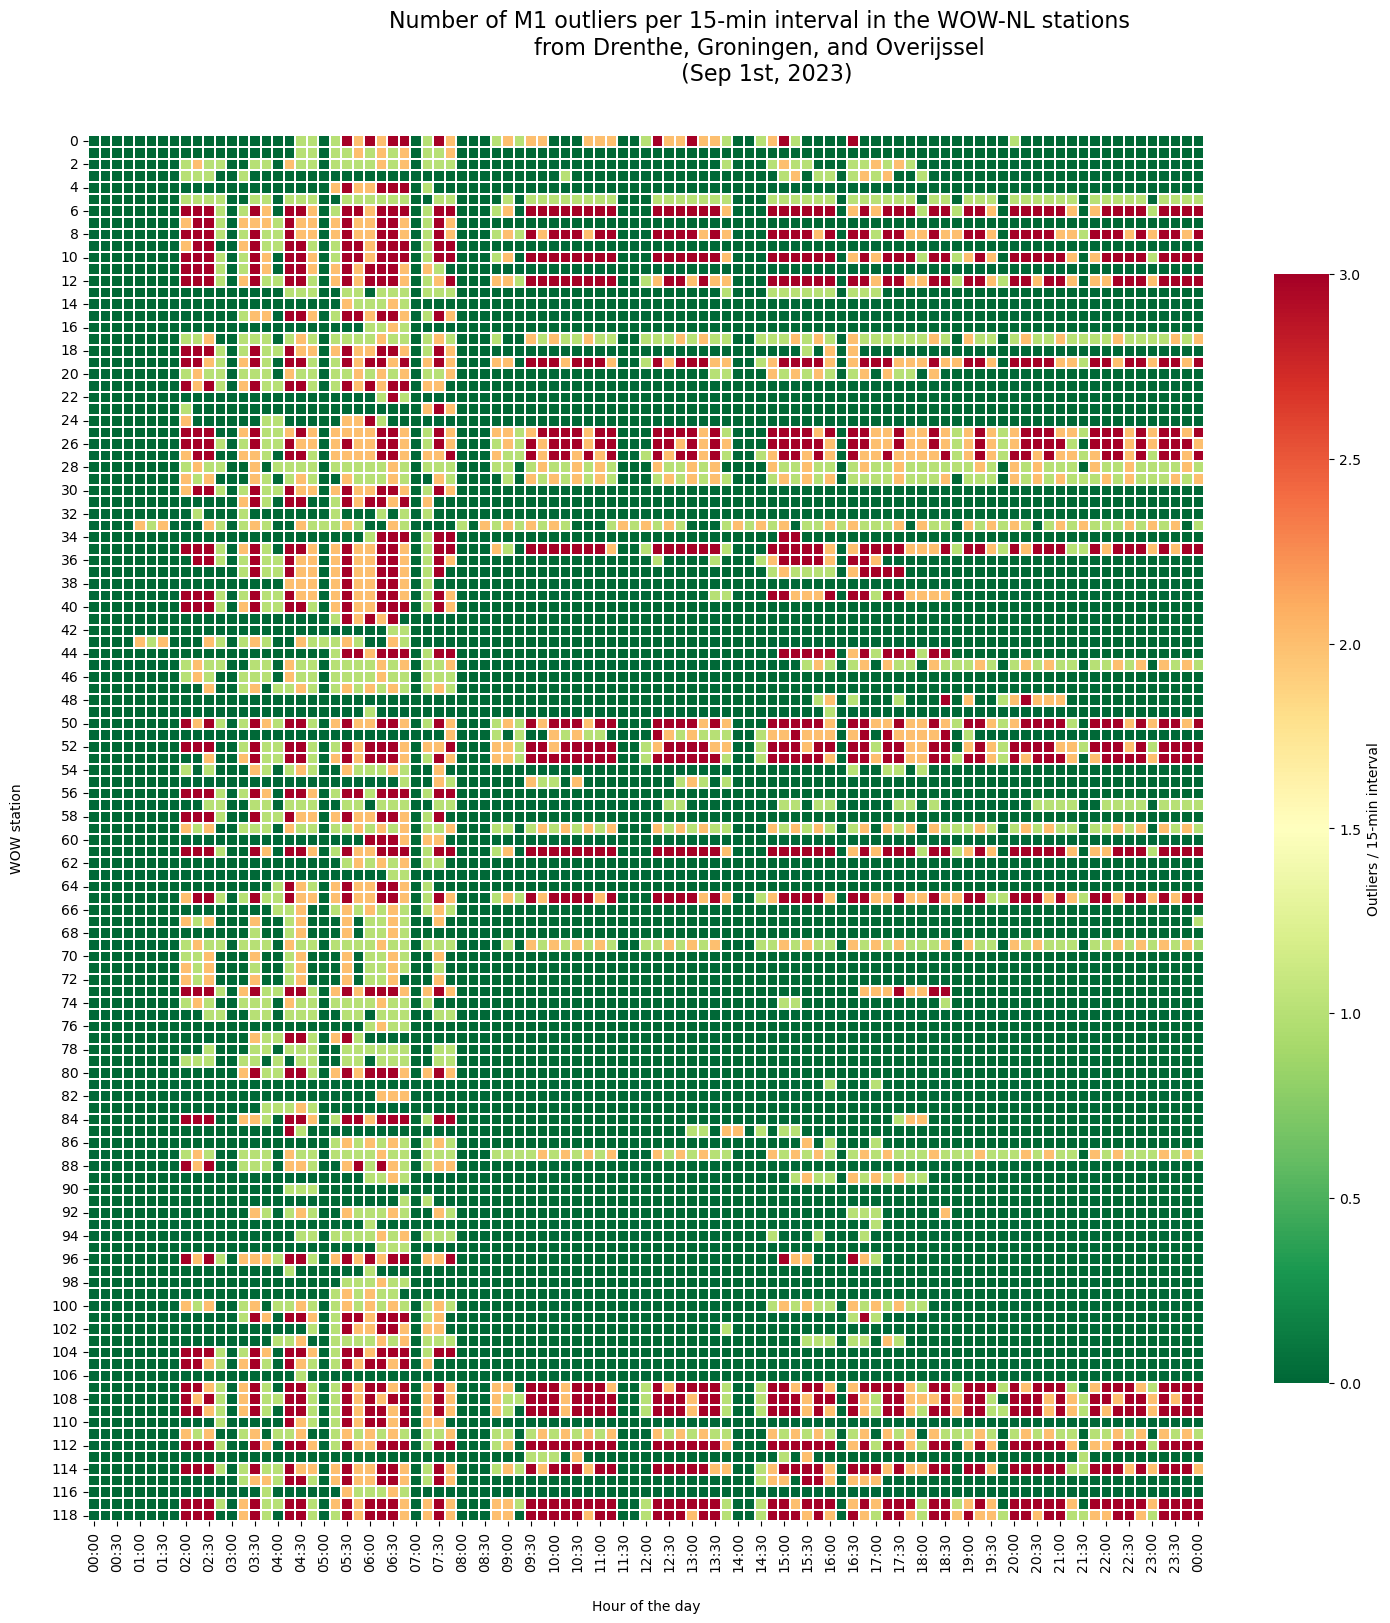

In [9]:
# Here we make a seaborn heatmap to show the quality over one day

xlabels = [quarters_in_a_day[i].strftime("%H:%M") for i in range(0, len(quarters_in_a_day), 2)]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 18))
plt.suptitle("Number of M1 outliers per 15-min interval in the WOW-NL stations \nfrom Drenthe, Groningen, and Overijssel \n (Sep 1st, 2023)", y=0.95, size=16)
plot = sb.heatmap(board, ax=ax, cmap=plt.cm.RdYlGn_r, robust=True, linewidths=.1, annot_kws={'size':11}, cbar_kws={'shrink':.8, 'label':'Outliers / 15-min interval', 'orientation':'vertical'})
ax.set_xticklabels(xlabels, rotation=90, fontsize=10);
ax.set_xlabel("Hour of the day", labelpad=20);
ax.set_ylabel("WOW station", labelpad=20);

## Exploring the vertical structure and linking it with city effects

### What is an outlier in this quality control?

Let's [check what the original paper](https://www.frontiersin.org/articles/10.3389/feart.2018.00118/full#B25) says: 


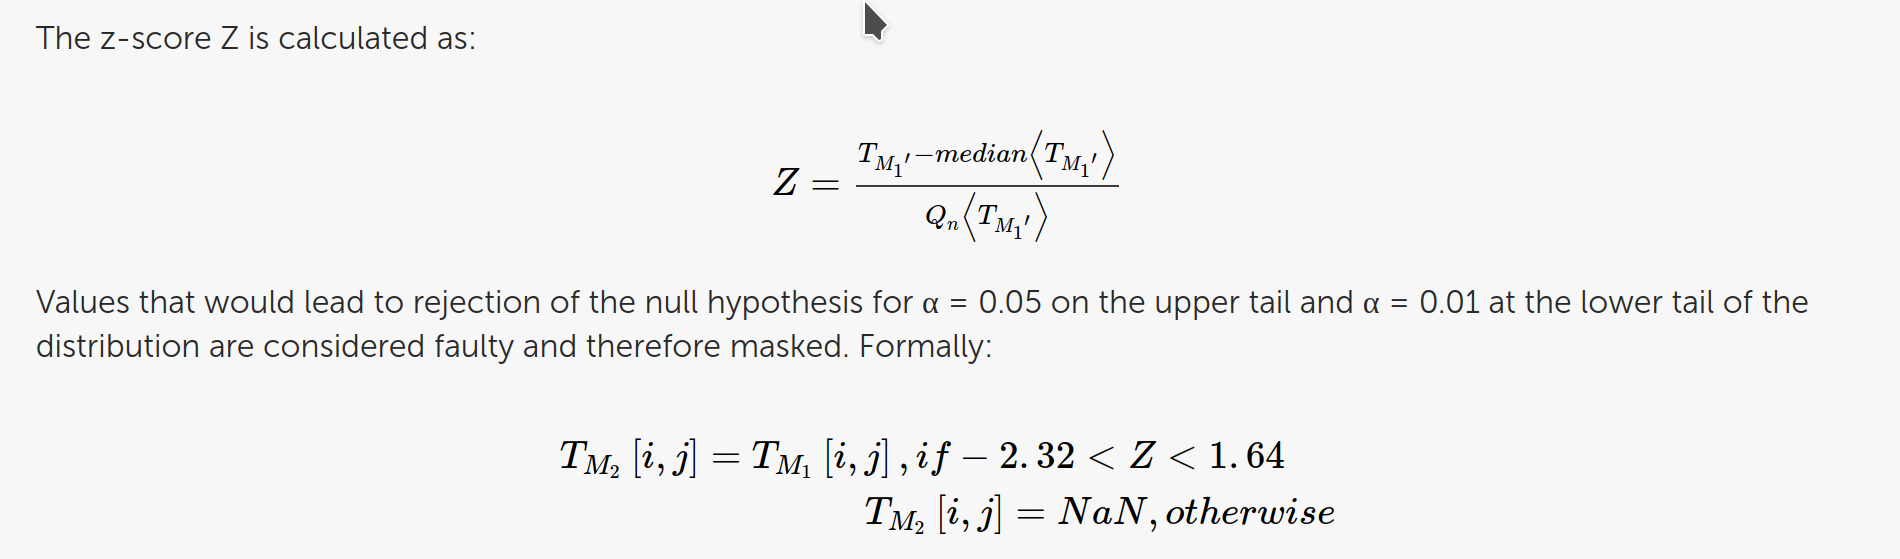

### Long-story short
- Sciency explanation: there are many 15-min slots with overdispersed temperature observations
- Plain language explanation: **"it's too hot in here tonight"**

### Let's find out about the location where stations are located

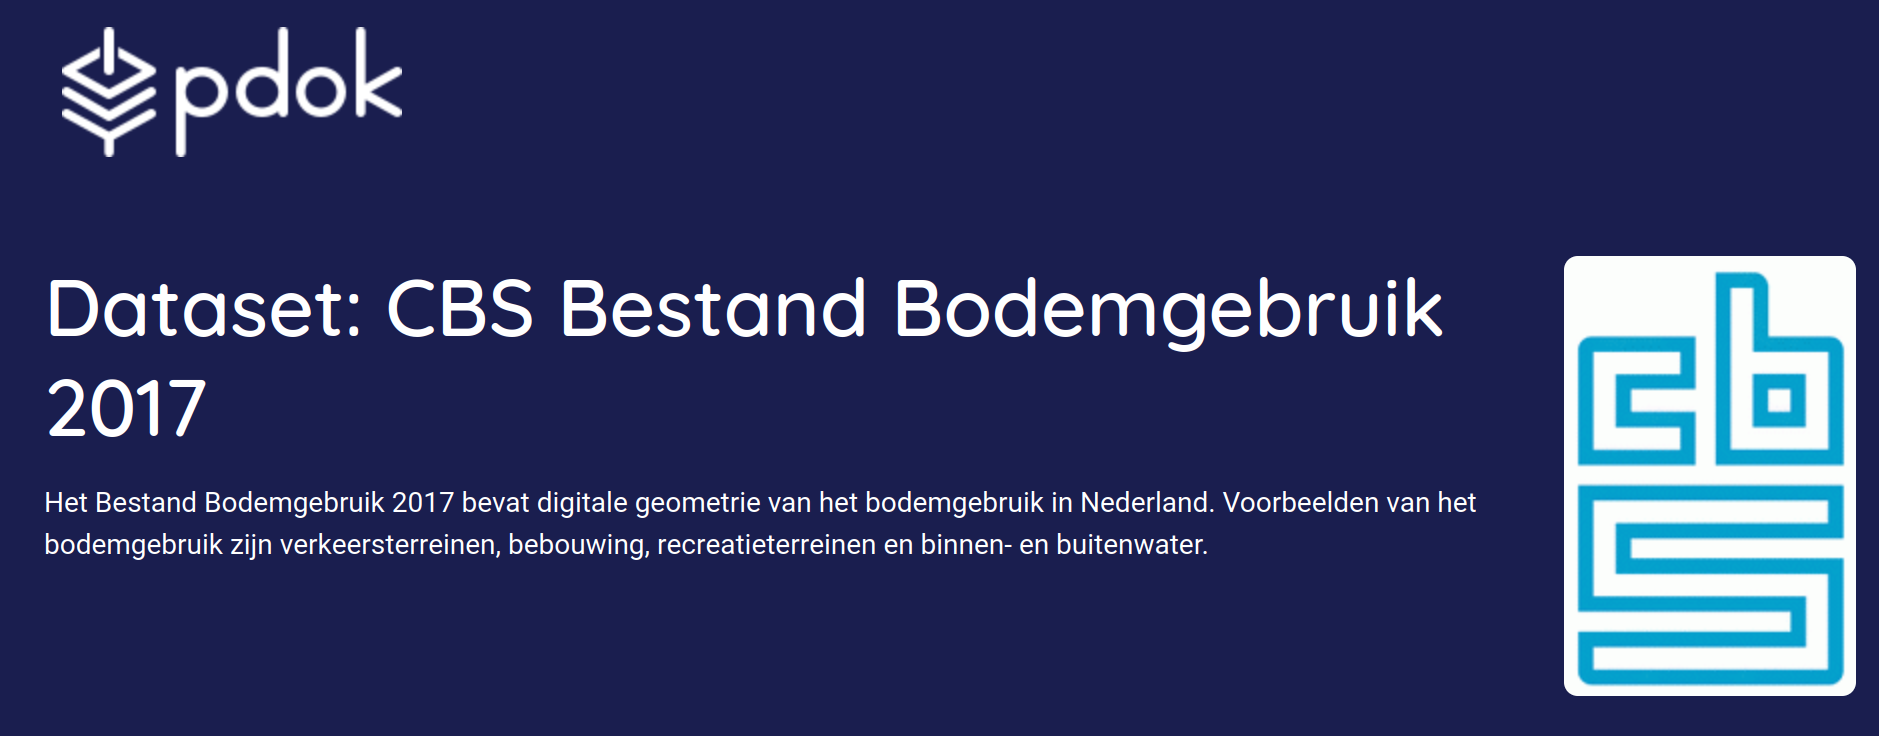

### Here begins the Python part

### Let's connect with PDOK.nl and find out the land use in each WOW location 
#### Note: slow computation, skipping cell is recommended

In [10]:
import json
import xmltodict
import geopandas as gpd
from requests import Request
from owslib.wfs import WebFeatureService
import xml.etree.ElementTree as etree

url = "https://service.pdok.nl/cbs/bestandbodemgebruik/2017/wfs/v1_0?request=getCapabilities&service=WFS"

# Initialize
wfs = WebFeatureService(url=url)
print("WFS: ", wfs)

gdf_m1 = gdf_m1.to_crs(epsg=28992)
gdf_m1_unique = gdf_m1.drop_duplicates(subset=['SiteId'], inplace=False)

k = 0
lcode, lname, lcate = [[]for i in range(3)]
for index, row in gdf_m1_unique.iterrows():
    if k % 20 == 0:
        print("Processing: ", k)
    xmin, ymin, xmax, ymax = [int(item) for item in row['geometry'].bounds]
    bbox = [xmin, ymin, xmax, ymax]
    subsets = [('x', xmin, xmax), ('y', ymin, ymax)]
    response = wfs.getfeature(typename=wfs.contents, bbox=bbox, srsname='urn:x-ogc:def:crs:EPSG:28992')
    dic = xmltodict.parse(response.read())
    lu_code = dic["wfs:FeatureCollection"]['gml:featureMember']['bestandbodemgebruik:BBG2017']['bestandbodemgebruik:bg2017']
    lu_name = dic["wfs:FeatureCollection"]['gml:featureMember']['bestandbodemgebruik:BBG2017']['bestandbodemgebruik:bodemgebruik']
    lu_cate = dic["wfs:FeatureCollection"]['gml:featureMember']['bestandbodemgebruik:BBG2017']['bestandbodemgebruik:categorie']
    lcode.append(lu_code)
    lname.append(lu_name)
    lcate.append(lu_cate)
    k += 1
    
gdf_m1_unique["lu_code"] = np.array(lcode);
gdf_m1_unique["lu_name"] = np.array(lname);
gdf_m1_unique["lu_cate"] = np.array(lcate);

ModuleNotFoundError: No module named 'xmltodict'

In [ ]:
# Since it's a long computation, we copy the dataframe and work with it
# to avoid deleting it by mistake
gdf_m1_copy = gdf_m1_unique.copy()

fig, ax = plt.subplots(figsize=(8, 8))
gdf_m1_copy['lu_cate'].value_counts(sort=True).plot.bar(ax=ax, rot=90)

#### Making a ranking of stations producing outliers

In [ ]:
board_binarized = np.where(board > 0, 1, board)
board_compressed = np.sum(board_binarized[:,0:37], axis=1)
gdf_m1_unique["total_outliers"] = board_compressed
gdf_sorted = gdf_m1_unique.sort_values(by='total_outliers', inplace=False, ascending=False)

for idx, row in gdf_sorted.iterrows():
    print(row[["SiteId", "Longitude", "Latitude", "PROVINCIENAAM", "lu_cate", "total_outliers"]].values.tolist())

In [ ]:
groups_station = gdf_m1.groupby(["SiteId"])

# This is just to print the contents and make the selection of the stations below
# for idx, group in groups_station:
#     matching_row = gdf_m1_copy.loc[gdf_m1_copy["SiteId"] == idx[0]]
#     print(idx, group.shape, matching_row["PROVINCIENAAM"].values[0], matching_row["lu_cate"].values[0]) 

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 12))
ax.set_title("Three time-series that look not-suspicious, yet they have some outliers")
plt.subplots_adjust(wspace=0.3, hspace=0.6)
ax.axvspan(datetime.datetime(2023, 9, 1, 2), datetime.datetime(2023, 9, 1, 8), alpha=0.5, color='lightgray')
ax.grid(visible=True)

# Picking one station per province over the "woongebied" land use
station_overijssel = "08a2a435-3a16-ed11-b5cf-0003ff5962a8"
station_groningen = "68b59f2b-f1a3-ed11-9ac4-0003ff598e21"
station_drenthe = "fe655d13-c639-ee11-913a-201642ba4c41"

group_overijssel = groups_station.get_group(station_overijssel).set_index("LocalReportEndDateTime")
group_groningen = groups_station.get_group(station_groningen).set_index("LocalReportEndDateTime")
group_drenthe = groups_station.get_group(station_drenthe).set_index("LocalReportEndDateTime")

group_overijssel.sort_values(by='LocalReportEndDateTime');
group_groningen.sort_values(by='LocalReportEndDateTime');
group_drenthe.sort_values(by='LocalReportEndDateTime');

group_overijssel["DryBulbTemperature_Celsius"].plot(label="Overijssel-average")
group_groningen["DryBulbTemperature_Celsius"].plot(label="Groningen-average")
group_drenthe["DryBulbTemperature_Celsius"].plot(label="Drenthe-average")

ax.legend()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 12))
ax.set_title("Three time-series with barely no outliers")
plt.subplots_adjust(wspace=0.3, hspace=0.6)
ax.axvspan(datetime.datetime(2023, 9, 1, 2), datetime.datetime(2023, 9, 1, 8), alpha=0.5, color='lightgray')
ax.grid(visible=True)

station_overijssel = "e17b709b-2913-ed11-b5cf-0003ff597f35"
station_groningen = "92137096-2d22-e911-9462-0003ff59610a"
station_drenthe = "bea6c3cd-3fa5-e811-b96f-0003ff5993a0"

group_overijssel = groups_station.get_group(station_overijssel).set_index("LocalReportEndDateTime")
group_groningen = groups_station.get_group(station_groningen).set_index("LocalReportEndDateTime")
group_drenthe = groups_station.get_group(station_drenthe).set_index("LocalReportEndDateTime")

group_overijssel.sort_values(by='LocalReportEndDateTime');
group_groningen.sort_values(by='LocalReportEndDateTime');
group_drenthe.sort_values(by='LocalReportEndDateTime');

group_overijssel["DryBulbTemperature_Celsius"].plot(label="Overijssel-few-outliers")
group_groningen["DryBulbTemperature_Celsius"].plot(label="Groningen-few-outliers")
group_drenthe["DryBulbTemperature_Celsius"].plot(label="Drenthe-few-outliers")

ax.legend()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 12))
ax.set_title("Three time-series with many outliers")
plt.subplots_adjust(wspace=0.3, hspace=0.6)
ax.axvspan(datetime.datetime(2023, 9, 1, 2), datetime.datetime(2023, 9, 1, 8), alpha=0.5, color='lightgray')
ax.grid(visible=True)

station_overijssel = "913976001"
station_groningen = "bea6c3cd-3fa5-e811-b96f-0003ff5993a0"
station_drenthe = "e17b709b-2913-ed11-b5cf-0003ff597f35"

group_overijssel = groups_station.get_group(station_overijssel).set_index("LocalReportEndDateTime")
group_groningen = groups_station.get_group(station_groningen).set_index("LocalReportEndDateTime")
group_drenthe = groups_station.get_group(station_drenthe).set_index("LocalReportEndDateTime")

group_overijssel.sort_values(by='LocalReportEndDateTime');
group_groningen.sort_values(by='LocalReportEndDateTime');
group_drenthe.sort_values(by='LocalReportEndDateTime');

group_overijssel["DryBulbTemperature_Celsius"].plot(label="Overijssel-many-outliers")
group_groningen["DryBulbTemperature_Celsius"].plot(label="Groningen-many-outliers")
group_drenthe["DryBulbTemperature_Celsius"].plot(label="Drenthe-many-outliers")

ax.legend()

In [ ]:
import seaborn as sb
vc = gdf_sorted["lu_cate"].value_counts()
print(vc)
ax = sb.heatmap(data=vc)

In [ ]:
# TODO: make a map with a divergent colorscale for the total_outliers kind of thing